In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 1
seed=67

dt = 0.05
t_data = [0,tf]

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

# Adaptive time-stepping for two cells after proliferation

In [5]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [6]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


## No Jacobian - accuracy bound only

Initial step cubic 0.022133523792153494
Stability bound estimate cubic 0.43156801471423156
Initial step pw. quad. 0.03710967349802411
Stability bound estimate pw. quad. 0.4276134366247075
Initial step GLS 0.05726279003770934
Stability bound estimate GLS 0.31499014039184403


Text(0, 0.5, '$\\Delta t$ in hours')

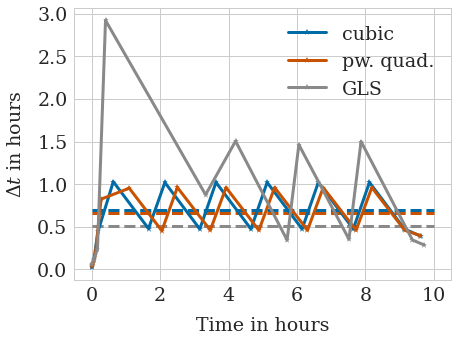

In [7]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.05,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.ylim([-0.1, 1.2])
#plt.savefig('adaptivity_pairwise_relaxation_eps0_05.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Initial step cubic 0.009898412756172828
Stability bound estimate cubic 0.5277024263481486
Initial step pw. quad. 0.01659595051288086
Stability bound estimate pw. quad. 0.5769993103071418
Initial step GLS 0.025608698221123164
Stability bound estimate GLS 0.31667583007187006


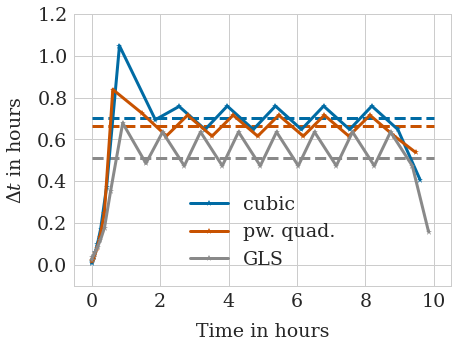

In [8]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Nothing to delete.
Initial step cubic 0.0031301529529971046
Stability bound estimate cubic 0.5681424435948421
Nothing to delete.
Initial step pw. quad. 0.005248100355614311
Stability bound estimate pw. quad. 0.4847047022597241
Nothing to delete.
Initial step GLS 0.00809818142906515
Stability bound estimate GLS 0.35746146595806866


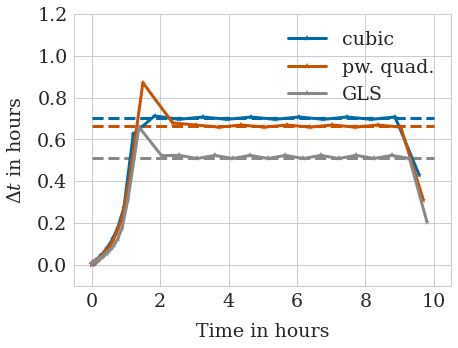

In [9]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


Initial step cubic 0.009898412756172828
Stability bound estimate cubic 0.5277024263481486
Initial step pw. quad. 0.01659595051288086
Stability bound estimate pw. quad. 0.5769993103071418
Initial step GLS 0.025608698221123164
Stability bound estimate GLS 0.31667583007187006
Initial step cubic 0.0031301529529971046
Stability bound estimate cubic 0.5681424435948421
Initial step pw. quad. 0.005248100355614311
Stability bound estimate pw. quad. 0.4847047022597241
Initial step GLS 0.00809818142906515
Stability bound estimate GLS 0.35746146595806866


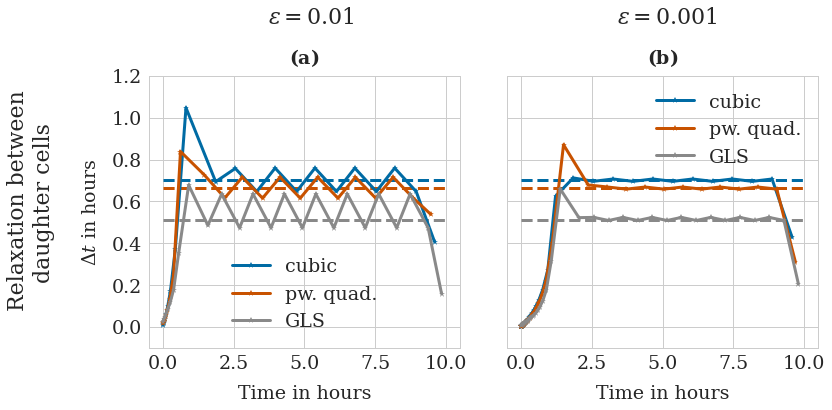

In [69]:

# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

#ax1
ax1.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
ax1.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
ax1.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    ax1.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




ax1.legend()
ax1.set_title(r'$\bf{(a)}$')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t$ in hours')
ax1.set(ylim=[-0.1, 1.2])
ax1.text(-5.5, 0.1, 'Relaxation between\n    daughter cells', fontsize=22, rotation='vertical')
ax1.text(3.7, 1.45, '$\epsilon=0.01$', fontsize=22)

#ax2
ax2.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
ax2.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
ax2.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax2.plot(ts[:-1], dts,'-*', label=force, color=colors[force])

ax2.set_title(r'$\bf{(b)}$')
ax2.legend()
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t$ in hours')
ax2.set(ylim=[-0.1, 1.2])
ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

plt.savefig('global_adap_relaxation_acc.pdf', bbox_inches='tight')

In [10]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


## Using the Jacobian to obtain the stability bound

In [11]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


(-0.1, 1.2)

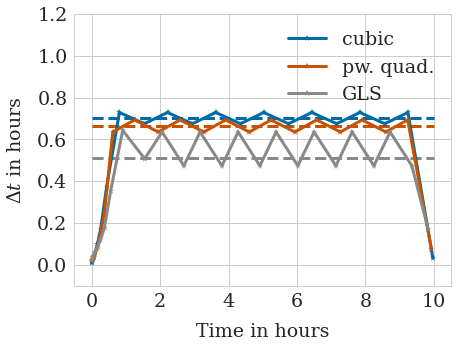

In [15]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

#force_names = ['cubic', 'pw. quad.']
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:, 0],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])


In [16]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


DEBUG:root:Starting new simulation
DEBUG:root:Calling solver with: t0=0, tf=10.0
DEBUG:root:Using EF, global adaptive time stepping with Jacobian and eps=0.001
DEBUG:root:t=0.0
DEBUG:root:Eigenvalues w=[-35.568   0.   ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.0031283661733253866
DEBUG:root:Eigenvalues w=[-33.07134412   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.0065621954410861015
DEBUG:root:Eigenvalues w=[-30.71080595   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.010338249517826659
DEBUG:root:Eigenvalues w=[-28.48145019   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.014498605599702473
DEBUG:root:Eigenvalues w=[-26.3784387   0.       ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.019091564179

DEBUG:root:t=0.03084285964929857
DEBUG:root:Eigenvalues w=[-14.582876   0.      ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.03866928718369301
DEBUG:root:Eigenvalues w=[-13.78619665   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.04720648853494769
DEBUG:root:Eigenvalues w=[-13.01364004   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.056543739266228424
DEBUG:root:Eigenvalues w=[-12.26534563   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.06678488832862402
DEBUG:root:Eigenvalues w=[-11.54147355   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.07805133848452493
DEBUG:root:Eigenvalues w=[-10.84220829   0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
D

DEBUG:root:Eigenvalues w=[-5.31346838  0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.20058197953004123
DEBUG:root:Eigenvalues w=[-5.10393206  0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.2279120728304568
DEBUG:root:Eigenvalues w=[-4.9193203  0.       ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.25787745464296774
DEBUG:root:Eigenvalues w=[-4.75651649  0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.2908331330046558
DEBUG:root:Eigenvalues w=[-4.61295295  0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.32722410276081526
DEBUG:root:Eigenvalues w=[-4.48650553  0.        ]
DEBUG:root:Eigenvectors v=[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
DEBUG:root:t=0.36761916587186616
DEBUG:root:Eig

(-0.1, 1.2)

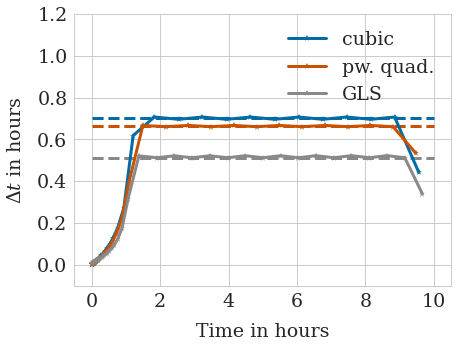

In [17]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

#force_names = ['cubic', 'pw. quad.']
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvalues'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('eigenvectors'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:, 0],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])



Initial step cubic [0.00989276 0.00989276 0.05623032]
Stability bound estimate cubic [0.38077346 1.01561743 0.70207957]
Initial step pw. quad. [0.01659212 0.01659212 0.1056841 ]
Stability bound estimate pw. quad. [0.38448998 0.87456007 0.66459854]
Initial step GLS [0.02559869 0.02559869 0.15384615]
Stability bound estimate GLS [0.3228595  0.55485866 0.5935129 ]
Initial step cubic [0.00312837 0.00312837 0.05623032]
Stability bound estimate cubic [0.57475167 0.70812184 0.70176797]
Initial step pw. quad. [0.00524689 0.00524689 0.1056841 ]
Stability bound estimate pw. quad. [0.59792079 0.87140221 0.66397471]
Initial step GLS [0.00809502 0.00809502 0.15384615]
Stability bound estimate GLS [0.42642533 0.61368097 0.51769822]


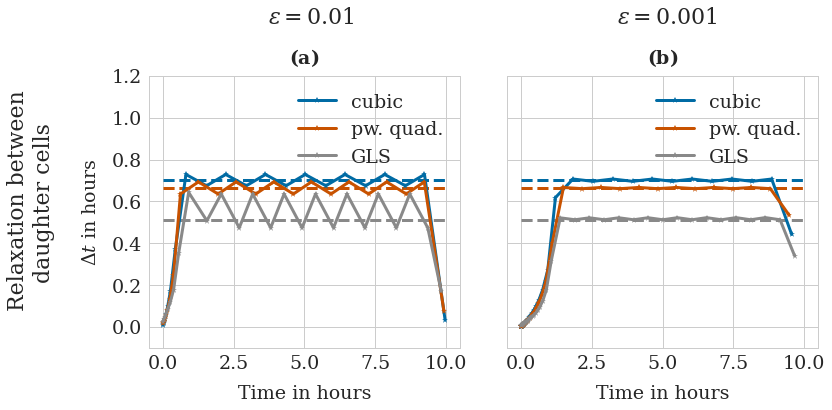

In [68]:

# Combine into single figure
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

#ax1
ax1.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
ax1.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
ax1.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    ax1.plot(ts[:-1], dts[:, 0],'-*', label=force, color=colors[force])
    #ax1.plot(ts[:-1], dts[:, 1],':' , color=colors[force], alpha=0.7)
    #ax1.plot(ts[:-1], dts[:, 2],'--', color=colors[force], alpha=0.7)



ax1.legend()
ax1.set_title(r'$\bf{(a)}$')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t$ in hours')
ax1.set(ylim=[-0.1, 1.2])
ax1.text(-5.5, 0.1, 'Relaxation between\n    daughter cells', fontsize=22, rotation='vertical')
ax1.text(3.7, 1.45, '$\epsilon=0.01$', fontsize=22)

#ax2
ax2.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
ax2.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
ax2.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax2.plot(ts[:-1], dts[:, 0],'-*', label=force, color=colors[force])
    #ax2.plot(ts[:-1], dts[:, 1],':' , color=colors[force], alpha=0.7)
    #ax2.plot(ts[:-1], dts[:, 2],'--', color=colors[force], alpha=0.7)

ax2.set_title(r'$\bf{(b)}$')
ax2.legend()
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t$ in hours')
ax2.set(ylim=[-0.1, 1.2])
ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

plt.savefig('global_adap_relaxation_stab.pdf', bbox_inches='tight')

In [54]:
dts

array([[0.00809502, 0.00809502, 0.15384615],
       [0.00905273, 0.00905273, 0.17333851],
       [0.01006259, 0.01006259, 0.19297713],
       [0.01113007, 0.01113007, 0.21264655],
       [0.0122617 , 0.0122617 , 0.23224203],
       [0.01346522, 0.01346522, 0.25166813],
       [0.01474988, 0.01474988, 0.27083761],
       [0.01612678, 0.01612678, 0.28967045],
       [0.01760927, 0.01760927, 0.3080931 ],
       [0.01921363, 0.01921363, 0.32603779],
       [0.0209598 , 0.0209598 , 0.34344198],
       [0.02287251, 0.02287251, 0.36024787],
       [0.02498279, 0.02498279, 0.37640198],
       [0.02733009, 0.02733009, 0.39185475],
       [0.02996538, 0.02996538, 0.40656023],
       [0.03295568, 0.03295568, 0.42047578],
       [0.03639097, 0.03639097, 0.43356176],
       [0.04039506, 0.04039506, 0.44578124],
       [0.04514331, 0.04514331, 0.45709974],
       [0.05089293, 0.05089293, 0.46748489],
       [0.05803792, 0.05803792, 0.47690608],
       [0.06721583, 0.06721583, 0.48533392],
       [0.

## Checking eigenvalues and eigenvectors

In [18]:
dts = np.loadtxt('step_sizes'+filename_ending['cubic']+'.txt')
len(dts)

43

In [19]:
eigenvalues_cubic = np.loadtxt('eigenvalues'+filename_ending['cubic']+'.txt')

In [20]:
eigenvalues_cubic

array([[-35.568     ,   0.        ],
       [-33.07134412,   0.        ],
       [-30.71080595,   0.        ],
       [-28.48145019,   0.        ],
       [-26.3784387 ,   0.        ],
       [-24.39703128,   0.        ],
       [-22.53258669,   0.        ],
       [-20.78056375,   0.        ],
       [-19.13652272,   0.        ],
       [-17.59612696,   0.        ],
       [-16.15514489,   0.        ],
       [-14.80945236,   0.        ],
       [-13.55503556,   0.        ],
       [-12.38799453,   0.        ],
       [-11.30454744,   0.        ],
       [-10.3010359 ,   0.        ],
       [ -9.37393144,   0.        ],
       [ -8.51984348,   0.        ],
       [ -7.73552932,   0.        ],
       [ -7.01790637,   0.        ],
       [ -6.36406745,   0.        ],
       [ -5.77129969,   0.        ],
       [ -5.23710809,   0.        ],
       [ -4.75924469,   0.        ],
       [ -4.33574491,   0.        ],
       [ -3.96497334,   0.        ],
       [ -3.64568301,   0.        ],
 

In [21]:
eigenvalues_cubic.shape

(43, 2)

In [22]:
eigenvectors_cubic = np.loadtxt('eigenvectors'+filename_ending['cubic']+'.txt')

In [23]:
eigenvectors_cubic.shape

(43, 4)

In [24]:
eigenvectors_cubic = eigenvectors_cubic.reshape((43,2,2), order='F')

In [25]:
eigenvectors_cubic[0, :, 0] # eigenvector corresponding to negative eigenvalue for time point 0

array([ 0.70710678, -0.70710678])

In [26]:
eigenvectors_cubic[0, :, 1] # eigenvector corresponding to zero eigenvalue for time point 0

array([0.70710678, 0.70710678])

Okay, this seems to be a translation of the system.

In [27]:
eigenvalues_pwq = np.loadtxt('eigenvalues'+filename_ending['pw. quad.']+'.txt')

In [28]:
eigenvalues_pwq

array([[-18.92432326,   0.        ],
       [-18.00859214,   0.        ],
       [-17.11650302,   0.        ],
       [-16.24812988,   0.        ],
       [-15.40355609,   0.        ],
       [-14.582876  ,   0.        ],
       [-13.78619665,   0.        ],
       [-13.01364004,   0.        ],
       [-12.26534563,   0.        ],
       [-11.54147355,   0.        ],
       [-10.84220829,   0.        ],
       [-10.16776338,   0.        ],
       [ -9.51838687,   0.        ],
       [ -8.89436821,   0.        ],
       [ -8.29604647,   0.        ],
       [ -7.72382062,   0.        ],
       [ -7.1781619 ,   0.        ],
       [ -6.65962909,   0.        ],
       [ -6.16888716,   0.        ],
       [ -5.70672973,   0.        ],
       [ -5.2741063 ,   0.        ],
       [ -4.8721544 ,   0.        ],
       [ -4.50223715,   0.        ],
       [ -4.16598606,   0.        ],
       [ -3.86534899,   0.        ],
       [ -3.60264485,   0.        ],
       [ -3.3806353 ,   0.        ],
 

Does the magnitude of the eigenvalue matter?

In [29]:
eigenvalues_gls = np.loadtxt('eigenvalues'+filename_ending['GLS']+'.txt')

In [30]:
eigenvalues_gls

array([[-13.        ,   0.        ],
       [-11.53811691,   0.        ],
       [-10.36392244,   0.        ],
       [ -9.4052783 ,   0.        ],
       [ -8.61170566,   0.        ],
       [ -7.9469736 ,   0.        ],
       [ -7.38449882,   0.        ],
       [ -6.90439777,   0.        ],
       [ -6.49154435,   0.        ],
       [ -6.13425831,   0.        ],
       [ -5.82339995,   0.        ],
       [ -5.55173301,   0.        ],
       [ -5.31346838,   0.        ],
       [ -5.10393206,   0.        ],
       [ -4.9193203 ,   0.        ],
       [ -4.75651649,   0.        ],
       [ -4.61295295,   0.        ],
       [ -4.48650553,   0.        ],
       [ -4.37541268,   0.        ],
       [ -4.2782131 ,   0.        ],
       [ -4.19369785,   0.        ],
       [ -4.12087413,   0.        ],
       [ -4.0589391 ,   0.        ],
       [ -4.00726373,   0.        ],
       [ -3.96538928,   0.        ],
       [ -3.93304609,   0.        ],
       [ -3.91023344,   0.        ],
 